# Leaf Counting

In [9]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [10]:
def show(img, title="Image", cmap=None):
    plt.figure(figsize=(6,6))
    if cmap is None:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [11]:
# Load sample image

img = cv2.imread("dataset/2.jpeg")   # TODO: Change path to your image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (7,7), 0)

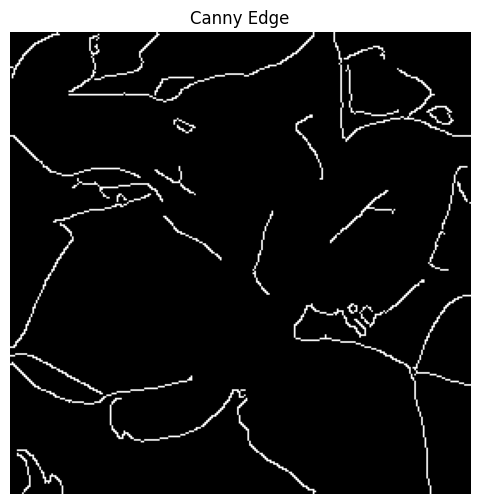

In [12]:
# Canny Edge Detection

edges = cv2.Canny(gray_blur, 50, 130)
show(edges, "Canny Edge", cmap="gray")

In [13]:
# Harris Corner Detection

harris = cv2.cornerHarris(np.float32(gray_blur), 2, 3, 0.04)
harris = cv2.dilate(harris, None)

corner_mask = harris > 0.01 * harris.max()
corner_points = np.column_stack(np.where(corner_mask))
print("Raw corners:", len(corner_points))

Raw corners: 1848


In [14]:
# Filter Corners by Angle

filtered_points = []
for y, x in corner_points:
    y0, y1 = max(0, y-4), min(gray.shape[0], y+5)
    x0, x1 = max(0, x-4), min(gray.shape[1], x+5)
    
    patch = gray[y0:y1, x0:x1]
    
    gx = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=3)
    
    angle = np.arctan2(gy.mean(), gx.mean()) * 180 / np.pi
    
    if -150 < angle < -30 or 30 < angle < 150:
        filtered_points.append([x, y])

filtered_points = np.array(filtered_points)
print("Filtered corners:", len(filtered_points))

Filtered corners: 1312


In [15]:
# DBSCAN Clustering of Leaf Tips

clustering = DBSCAN(eps=35, min_samples=8).fit(filtered_points) # TODO: Tune parameters
labels = clustering.labels_

unique_clusters = set(labels)
unique_clusters.discard(-1)   # remove noise

# Filter small clusters
final_clusters = []
for cluster_id in unique_clusters:
    pts = filtered_points[labels == cluster_id]
    if len(pts) >= 10:  # keep clusters with enough points
        final_clusters.append(cluster_id)

leaf_count = len(final_clusters)
print("Estimated Leaf Count (filtered):", leaf_count)

Estimated Leaf Count (filtered): 7


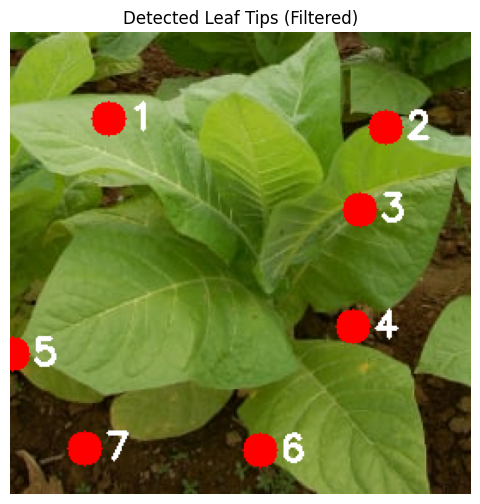

In [16]:
# Visualize Results

tip_img = img.copy()

for i, cluster_id in enumerate(final_clusters):
    pts = filtered_points[labels == cluster_id]
    cx, cy = pts.mean(axis=0).astype(int)
    cv2.circle(tip_img, (cx, cy), 10, (0, 0, 255), -1)
    cv2.putText(tip_img, str(i+1), (cx+12, cy+6),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

show(tip_img, "Detected Leaf Tips (Filtered)")